In [31]:
import numpy as np
import pandas as pd
from functools import reduce
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
from operator import itemgetter
import time
import sys
import warnings

In [70]:
df_China_BAB_returns=pd.read_pickle('../output/China/Portfolio Beta and Return Daily/return.pickle')[['BAB']]
df_US_BAB_returns=pd.read_pickle('../output/US/Portfolio Beta and Return Daily/return.pickle')[['BAB']]

In [71]:
df_return_merged = df_China_BAB_returns.merge(df_US_BAB_returns,left_index=True,right_index=True,suffixes=('_China', '_US'))
df_return_merged = df_return_merged.astype('float')

df_level = (df_return_merged+1).cumprod()
df_level= df_level.append(pd.DataFrame(index=[pd.to_datetime('2008-01-01')],data={'BAB_China':1,'BAB_US':1}))
df_level = df_level.sort_index()
df_level= df_level*100

/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  """


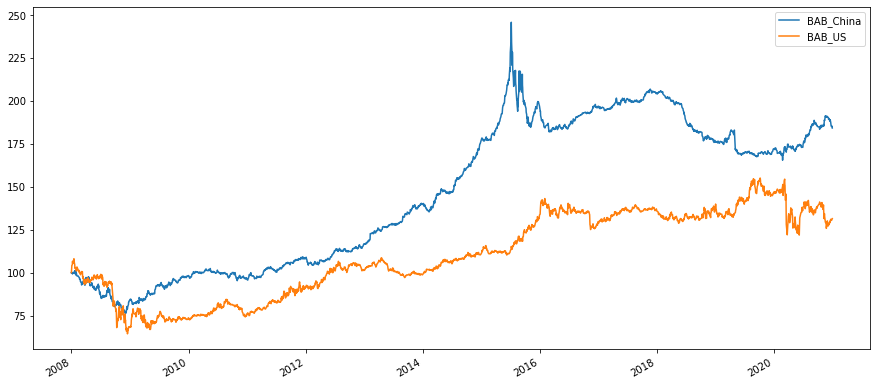

In [72]:
fig, ax = plt.subplots(figsize=(15,7))
df_level.BAB_China.plot(ax=ax)
df_level.BAB_US.plot(ax=ax)
plt.legend()
plt.show()

In [73]:
import bt

In [45]:
np.corrcoef(df_return_merged,rowvar=False)

array([[ 1.        , -0.01094509],
       [-0.01094509,  1.        ]])

In [46]:
# algo to fire on the beginning of every month and to run on the first date
runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True
)

# algo to set the weights
#  it will only run when runMonthlyAlgo returns true
#  which only happens on the first of every month
weights = pd.Series([1,0],index = df_level.columns)
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)

# algo to rebalance the current weights to weights set by weighSpecified
#  will only run when weighSpecifiedAlgo returns true
#  which happens every time it runs
rebalAlgo = bt.algos.Rebalance()

# a strategy that rebalances monthly to specified weights
strat = bt.Strategy('buy_and_hold_China',
    [
        runMonthlyAlgo,
        weighSpecifiedAlgo,
        rebalAlgo
    ]
)

buy_and_hold_China = bt.Backtest(
    strat,
    df_level,
    integer_positions=False
)

In [47]:
# algo to fire on the beginning of every month and to run on the first date
runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True
)

# algo to set the weights
#  it will only run when runMonthlyAlgo returns true
#  which only happens on the first of every month
weights = pd.Series([0,1],index = df_level.columns)
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)

# algo to rebalance the current weights to weights set by weighSpecified
#  will only run when weighSpecifiedAlgo returns true
#  which happens every time it runs
rebalAlgo = bt.algos.Rebalance()

# a strategy that rebalances monthly to specified weights
strat = bt.Strategy('buy_and_hold_US',
    [
        runMonthlyAlgo,
        weighSpecifiedAlgo,
        rebalAlgo
    ]
)

buy_and_hold_US = bt.Backtest(
    strat,
    df_level,
    integer_positions=False
)

In [48]:
# create our new strategy
s = bt.Strategy('Equal Weight Monthly', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])
s2 = bt.Strategy('Inverse Vol Monthly', [bt.algos.RunMonthly(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighInvVol(),
                        bt.algos.Rebalance()])
s3 = bt.Strategy('Mean Variance Monthly', [bt.algos.RunMonthly(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighMeanVar(lookback=pd.DateOffset(years=1)),
                        bt.algos.Rebalance()])
# now let's test it with the same data set. We will also compare it with our first backtest.
test = bt.Backtest(s, df_level)
test2 = bt.Backtest(s2, df_level)
test3 = bt.Backtest(s3, df_level)

# we include test here to see the results side-by-side
res2 = bt.run(buy_and_hold_China,buy_and_hold_US,test,test2)#,test3)


<AxesSubplot:title={'center':'Strategy Backtesting'}>

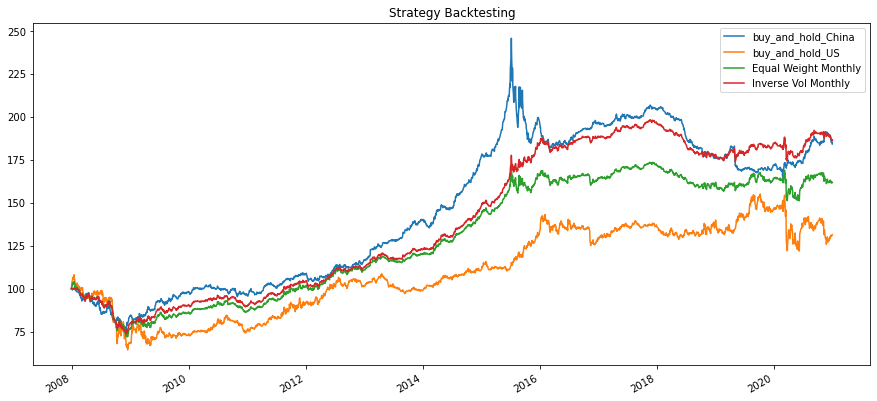

In [49]:
fig,ax=plt.subplots()
res2.plot(ax=ax,figsize=(15,7),title='Strategy Backtesting')


In [50]:
res2.display()

Stat                 buy_and_hold_China    buy_and_hold_US    Equal Weight Monthly    Inverse Vol Monthly
-------------------  --------------------  -----------------  ----------------------  ---------------------
Start                2007-12-31            2007-12-31         2007-12-31              2007-12-31
End                  2020-12-31            2020-12-31         2020-12-31              2020-12-31
Risk-free rate       0.00%                 0.00%              0.00%                   0.00%

Total Return         84.18%                31.40%             61.76%                  86.13%
Daily Sharpe         0.65                  0.23               0.54                    0.82
Daily Sortino        1.03                  0.35               0.83                    1.29
CAGR                 4.81%                 2.12%              3.77%                   4.89%
Max Drawdown         -32.68%               -40.45%            -30.89%                 -26.39%
Calmar Ratio         0.15             

In [74]:
df_level = df_level['2009-01-01':'2020-01-01']

In [75]:
df_level

,BAB_China,BAB_US
2009-01-05,84.584538,68.665611
2009-01-06,84.031480,68.221762
2009-01-07,83.970199,69.646390
2009-01-08,84.259514,69.810340
2009-01-09,83.722531,72.311246
...,...,...
2019-12-23,170.373841,144.790470
2019-12-24,170.587709,145.152967
2019-12-26,170.753332,145.253401
2019-12-27,171.458766,146.086768


In [76]:
# algo to fire on the beginning of every month and to run on the first date
runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True
)

# algo to set the weights
#  it will only run when runMonthlyAlgo returns true
#  which only happens on the first of every month
weights = pd.Series([1,0],index = df_level.columns)
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)

# algo to rebalance the current weights to weights set by weighSpecified
#  will only run when weighSpecifiedAlgo returns true
#  which happens every time it runs
rebalAlgo = bt.algos.Rebalance()

# a strategy that rebalances monthly to specified weights
strat = bt.Strategy('buy_and_hold_China',
    [
        runMonthlyAlgo,
        weighSpecifiedAlgo,
        rebalAlgo
    ]
)

buy_and_hold_China = bt.Backtest(
    strat,
    df_level,
    integer_positions=False
)

In [77]:
# create our new strategy
s = bt.Strategy('Equal Weight Monthly', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])
s2 = bt.Strategy('Inverse Vol Monthly', [bt.algos.RunMonthly(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighInvVol(),
                        bt.algos.Rebalance()])
s3 = bt.Strategy('Mean Variance Monthly', [bt.algos.RunMonthly(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighMeanVar(lookback=pd.DateOffset(years=1)),
                        bt.algos.Rebalance()])
# now let's test it with the same data set. We will also compare it with our first backtest.
test = bt.Backtest(s, df_level)
test2 = bt.Backtest(s2, df_level)
test3 = bt.Backtest(s3, df_level)

# we include test here to see the results side-by-side
res2 = bt.run(buy_and_hold_China,buy_and_hold_US,test,test2)#,test3)


<AxesSubplot:title={'center':'Strategy Backtesting'}>

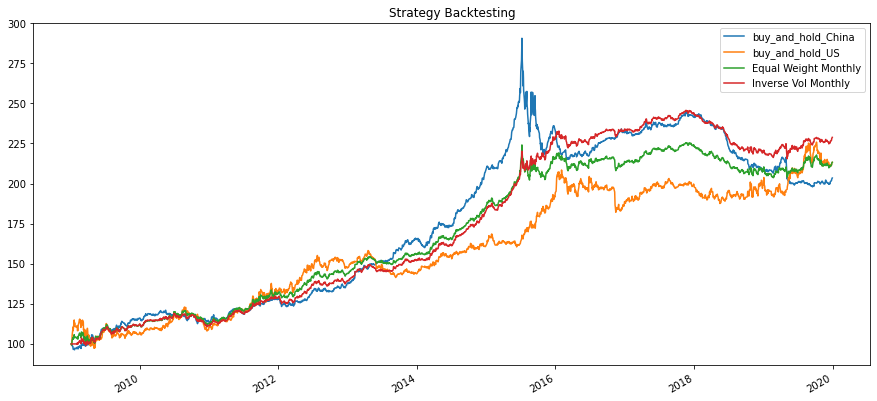

In [78]:
fig,ax=plt.subplots()
res2.plot(ax=ax,figsize=(15,7),title='Strategy Backtesting')


In [79]:
res2.display()

Stat                 buy_and_hold_China    buy_and_hold_US    Equal Weight Monthly    Inverse Vol Monthly
-------------------  --------------------  -----------------  ----------------------  ---------------------
Start                2009-01-05            2009-01-05         2009-01-05              2009-01-05
End                  2019-12-30            2019-12-30         2019-12-30              2019-12-30
Risk-free rate       0.00%                 0.00%              0.00%                   0.00%

Total Return         103.44%               113.20%            113.24%                 128.77%
Daily Sharpe         0.96                  0.73               1.13                    1.49
Daily Sortino        1.51                  1.21               1.89                    2.56
CAGR                 6.68%                 7.14%              7.14%                   7.83%
Max Drawdown         -31.88%               -15.57%            -9.77%                  -12.27%
Calmar Ratio         0.21            